Relationship of ketones with outcome after ischemic stroke

Ketones not in dataset -> use anion gap as surrogate

In [34]:
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr
from statsmodels.miscmodels.ordinal_model import OrderedModel
import seaborn as sns
import matplotlib.pyplot as plt
from utils import create_registry_case_identification_column, create_ehr_case_identification_column, patient_selection
from utils import load_data_from_main_dir
from lab_preprocessing import preprocess_labs
from outcome_preprocessing import preprocess_outcomes


In [2]:
eds_path = '/Users/jk1/stroke_datasets/stroke_unit_dataset/per_value/Extraction_20221117/eds_j1.csv'
ehr_data_path = '/Users/jk1/stroke_datasets/stroke_unit_dataset/per_value/Extraction_20221117/'
registry_path = '/Users/jk1/Library/CloudStorage/OneDrive-unige.ch/stroke_research/geneva_stroke_unit_dataset/data/stroke_registry/post_hoc_modified/stroke_registry_post_hoc_modified.xlsx'

In [3]:
eds_df = pd.read_csv(eds_path, delimiter=';', encoding='utf-8',
                         dtype=str)
registry_df = pd.read_excel(registry_path, dtype=str)

In [4]:
registry_df['case_admission_id'] = create_registry_case_identification_column(registry_df)
eds_df['case_admission_id'] = create_ehr_case_identification_column(eds_df)

In [5]:
inclusion_registry_df, excluded_patients_df = patient_selection(
    registry_path=registry_path,
    eds_path=eds_path,
    exclude_patients_under_18=True,
    exclude_non_ischemic_stroke=True,
    exclude_non_acute_stroke=True,
    verbose=True
)

Number of records screened:  5152 after removing duplicates:  12
153 patients refuse the use of their data
Number of patients excluded because not ischemic stroke:  1726
Number of patients excluded because non acute stroke:  139
Number of patients excluded because under 18:  1
Number of patients excluded because intra-hospital stroke:  209


In [6]:
eds_df['case_admission_id'] = eds_df[eds_df['case_admission_id'].isin(inclusion_registry_df['case_admission_id'])]['case_admission_id']
print(f'Number of patients in EDS after selection: {eds_df.patient_id.nunique()}')

Number of patients in EDS after selection: 3121


In [7]:
lab_file_start = 'labo'
lab_df = load_data_from_main_dir(ehr_data_path, lab_file_start)
lab_df['case_admission_id'] = create_ehr_case_identification_column(lab_df)

In [18]:
preprocessed_anion_gap_df = preprocess_labs(lab_df, ["sodium", "chlore", "HCO3", "lactate"])

sodium ['mmol/l']
chlore ['mmol/l']
HCO3 ['mmol/l']
lactate ['mmol/l']
Remaining non-numerical values: []
Excluding 1 observations because out of range
Median observations per case admission id:
              median_observations_per_case_admission_id
dosage_label                                           
HCO3                                                2.0
chlore                                              1.0
lactate                                             1.0
sodium                                              5.0
Descriptive statistics:
                count        mean       std    min    25%    50%    75%    max
dosage_label                                                                  
HCO3          17966.0   24.650551  3.568749    2.3   22.6   24.6   26.7   47.2
chlore        10794.0  107.515935  5.359388   71.0  104.0  107.0  111.0  143.0
lactate        9132.0    1.341251  1.186077    0.1    0.7    1.0    1.5   21.0
sodium        26680.0  139.672001  4.427427  111.0

/Users/jk1/stroke_research/collaterals/lab_preprocessing.py:195: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_observations_per_case_admission_id_df = median_observations_per_case_admission_id.groupby('dosage_label').median()


In [23]:
preprocessed_anion_gap_df = preprocessed_anion_gap_df.pivot_table(index=['case_admission_id', "sample_date"], columns='dosage_label', values='value').reset_index()

<AxesSubplot:>

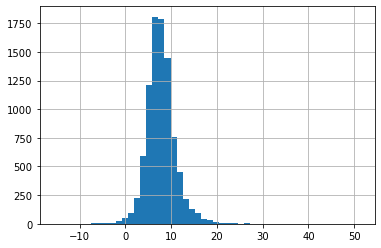

In [26]:
preprocessed_anion_gap_df['anion_gap'] = preprocessed_anion_gap_df['sodium'] - (preprocessed_anion_gap_df['chlore'] + preprocessed_anion_gap_df['HCO3'])
preprocessed_anion_gap_df['anion_gap'].hist(bins=50)

In [27]:
# create non_lactate anion gap column (anion gap if lactate < 2.5)
preprocessed_anion_gap_df['non_lactate_anion_gap'] = preprocessed_anion_gap_df.apply(
    lambda row: row['anion_gap'] if row['lactate'] < 2.5 else None, axis=1
)

In [30]:
preprocessed_anion_gap_df[preprocessed_anion_gap_df['non_lactate_anion_gap'].notnull()].nunique()

dosage_label
case_admission_id        2115
sample_date              8145
HCO3                      578
chlore                     61
lactate                    23
sodium                     64
anion_gap                 517
non_lactate_anion_gap     517
dtype: int64

In [32]:
inclusion_registry_df['T0'] = inclusion_registry_df['stroke_dt'].fillna(inclusion_registry_df['arrival_dt'])
preprocessed_anion_gap_df = preprocessed_anion_gap_df.merge(
    inclusion_registry_df[['case_admission_id', 'T0']],
    on='case_admission_id',
    how='left'
)

In [33]:
dt_format = '%d.%m.%Y %H:%M'
preprocessed_anion_gap_df['relative_sample_date'] = (pd.to_datetime(preprocessed_anion_gap_df['sample_date'], format=dt_format) - pd.to_datetime(preprocessed_anion_gap_df['T0'], format=dt_format)).dt.total_seconds() / 3600 # convert to hours

In [35]:
preprocessed_anion_gap_df['relative_sample_date_hcat'] = preprocessed_anion_gap_df['relative_sample_date'].apply(np.floor)

In [36]:
preprocessed_anion_gap_df.case_admission_id.nunique()

3265

In [41]:
n_patients_with_ag_in_first_24h = preprocessed_anion_gap_df[(preprocessed_anion_gap_df.relative_sample_date > -12) & (preprocessed_anion_gap_df.relative_sample_date < 24) 
                                                            & (preprocessed_anion_gap_df.non_lactate_anion_gap.notna())].case_admission_id.nunique()
n_patients_with_ag_in_24_to_72h = preprocessed_anion_gap_df[(preprocessed_anion_gap_df.relative_sample_date > 24) & (preprocessed_anion_gap_df.relative_sample_date < 3*24)
                                                            & (preprocessed_anion_gap_df.non_lactate_anion_gap.notna())].case_admission_id.nunique()

print(f'Number of patients with anion gap in first 24h: {n_patients_with_ag_in_first_24h}')
print(f'Number of patients with anion gap in 24 to 72h: {n_patients_with_ag_in_24_to_72h}')

Number of patients with anion gap in first 24h: 1600
Number of patients with anion gap in 24 to 72h: 435


In [38]:
outcome_df = preprocess_outcomes(registry_path)
outcome_df = outcome_df[outcome_df.case_admission_id.isin(inclusion_registry_df.case_admission_id.unique())]
outcome_df.drop_duplicates(subset='case_admission_id', keep='first', inplace=True)

/Users/jk1/stroke_research/collaterals/outcome_preprocessing.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_df['3M mRS 0-1'] = np.where(outcome_df['3M mRS'].isna(), np.nan, np.where(outcome_df['3M mRS'] <= 1, 1, 0))
/Users/jk1/stroke_research/collaterals/outcome_preprocessing.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_df['3M mRS 0-2'] = np.where(outcome_df['3M mRS'].isna(), np.nan, np.where(outcome_df['3M mRS'] <= 2, 1, 0))


In [39]:
preprocessed_anion_gap_df = preprocessed_anion_gap_df.merge(
    outcome_df[['case_admission_id', '3M mRS']],
    on='case_admission_id',
    how='left'
)

In [40]:
preprocessed_anion_gap_df

case_admission_id       sample_date   HCO3  chlore  lactate  sodium  \
0           100023_4784  19.11.2019 04:35  25.40   106.0      1.6   140.0   
1           100023_4784  19.11.2019 04:40    NaN     NaN      NaN   140.0   
2           100023_4784  19.11.2019 06:50    NaN     NaN      NaN   136.0   
3          1002417_9090  03.03.2020 09:50  24.95   100.0      3.9   135.0   
4          1002417_9090  03.03.2020 09:55    NaN     NaN      NaN   134.0   
...                 ...               ...    ...     ...      ...     ...   
26525        99861_8196  17.04.2020 00:25    NaN     NaN      NaN   136.0   
26526        99960_7802  21.03.2020 23:00    NaN     NaN      NaN   137.0   
26527        99960_7802  21.03.2020 23:14  23.95   105.0      1.7   133.0   
26528         9996_3256  05.11.2020 17:05    NaN     NaN      NaN   141.0   
26529         9996_3256  06.11.2020 07:00    NaN     NaN      NaN   138.0   

       anion_gap  non_lactate_anion_gap                T0  \
0           8.60                   8.60  19.11.2019 00:30   
1            NaN                    NaN  19.11.2019 00:30   
2            NaN                    NaN  19.11.2019 00:30   
3          10.05                    NaN  03.03.2020 03:30   
4            NaN                    NaN  03.03.2020 03:30   
...          ...                    ...               ...   
26525        NaN                    NaN  10.04.2020 23:00   
26526        NaN                    NaN               NaN   
26527       4.05                   4.05               NaN   
26528        NaN                    NaN  04.11.2020 12:00   
26529        NaN                    NaN  04.11.2020 12:00   

       relative_sample_date  relative_sample_date_hcat  3M mRS  
0                  4.083333                        4.0     0.0  
1                  4.166667                        4.0     0.0  
2                  6.333333                        6.0     0.0  
3                  6.333333                        6.0     4.0  
4                  6.416667                        6.0     4.0  
...                     ...                        ...     ...  
26525            145.416667                      145.0     3.0  
26526                   NaN                        NaN     NaN  
26527                   NaN                        NaN     NaN  
26528             29.083333                       29.0     0.0  
26529             43.000000                       43.0     0.0  

[26530 rows x 12 columns]

In [ ]:
# Overall correlation between non-lactate anion gap and 3M mRS

temp_df = preprocessed_anion_gap_df[preprocessed_anion_gap_df['non_lactate_anion_gap'].notna() & preprocessed_anion_gap_df['3M mRS'].notna()]
temp_df['3M mRS'] = temp_df['3M mRS'].astype(int)
corr, p_value = pearsonr(temp_df['non_lactate_anion_gap'], temp_df['3M mRS'])
print(f'Pearson correlation: {corr}, p-value: {p_value}')

Pearson correlation: 0.016678016656211006, p-value: 0.20641105631556753


/var/folders/9v/1s329cwj32jc2kkx24p8jp980000gp/T/ipykernel_11715/1694633995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['3M mRS'] = temp_df['3M mRS'].astype(int)


In [43]:
early_anion_gap_df = preprocessed_anion_gap_df[(preprocessed_anion_gap_df.relative_sample_date > -12) & (preprocessed_anion_gap_df.relative_sample_date < 24)]
anion_gap_d2_df = preprocessed_anion_gap_df[(preprocessed_anion_gap_df.relative_sample_date > 24) & (preprocessed_anion_gap_df.relative_sample_date < 2*72)]
anion_gap_d3_df = preprocessed_anion_gap_df[(preprocessed_anion_gap_df.relative_sample_date > 2*24) & (preprocessed_anion_gap_df.relative_sample_date < 3*72)]
anion_gap_d_2_3_df = preprocessed_anion_gap_df[(preprocessed_anion_gap_df.relative_sample_date > 1*24) & (preprocessed_anion_gap_df.relative_sample_date < 3*72)]

In [44]:
# correlation of early anion gap with outcome
temp_df = early_anion_gap_df.dropna(subset=['non_lactate_anion_gap', '3M mRS'])
corr, p_value = pearsonr(temp_df['non_lactate_anion_gap'], temp_df['3M mRS'])
print(f'Pearson correlation: {corr}, p-value: {p_value}')

Pearson correlation: 0.004452432663779398, p-value: 0.8284866305105699


In [45]:
# correlation of d2 anion gap with outcome
temp_df = anion_gap_d2_df.dropna(subset=['non_lactate_anion_gap', '3M mRS'])
corr, p_value = pearsonr(temp_df['non_lactate_anion_gap'], temp_df['3M mRS'])
print(f'Pearson correlation: {corr}, p-value: {p_value}')

Pearson correlation: -0.026710566263372804, p-value: 0.24893280504811402


In [46]:
# correlation of d3 anion gap with outcome
temp_df = anion_gap_d3_df.dropna(subset=['non_lactate_anion_gap', '3M mRS'])
corr, p_value = pearsonr(temp_df['non_lactate_anion_gap'], temp_df['3M mRS'])
print(f'Pearson correlation: {corr}, p-value: {p_value}')

Pearson correlation: 0.014410438144641591, p-value: 0.5874211621136138


In [47]:
# correlation of d2-d3 anion gap with outcome
temp_df = anion_gap_d_2_3_df.dropna(subset=['non_lactate_anion_gap', '3M mRS'])
corr, p_value = pearsonr(temp_df['non_lactate_anion_gap'], temp_df['3M mRS'])
print(f'Pearson correlation: {corr}, p-value: {p_value}')


Pearson correlation: 0.0011540214250809692, p-value: 0.9566323922681046
